# 階層的クラスタリング


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
# データ読み込み
df = pd.read_table('./input/count_tpm.tsv', index_col=0)
print(df.head())
print(len(df))

            batch_1   batch_2   batch_3  chemostat_1  chemostat_2  chemostat_3
gene_id                                                                       
gene_0001  0.468035  1.053365  0.984620     0.000000     0.000000     0.195379
gene_0002  0.000000  0.000000  0.000000     0.000000     0.000000     0.000000
gene_0003  0.000000  0.000000  0.000000     0.000000     0.000000     0.000000
gene_0004  0.000000  0.329347  0.000000     0.000000     0.000000     0.000000
gene_0005  1.783694  2.676265  4.221463     5.882705     1.482946     2.930690
5983


In [3]:
# 全サンプルでTPMがゼロの遺伝子のレコードを削除
all_zero_index = df.index[df.sum(axis=1) == 0]
df = df.drop(all_zero_index)
print(df.head())
print(len(df))

            batch_1   batch_2   batch_3  chemostat_1  chemostat_2  chemostat_3
gene_id                                                                       
gene_0001  0.468035  1.053365  0.984620     0.000000     0.000000     0.195379
gene_0004  0.000000  0.329347  0.000000     0.000000     0.000000     0.000000
gene_0005  1.783694  2.676265  4.221463     5.882705     1.482946     2.930690
gene_0009  1.241373  1.156074  1.305757     3.035284    14.335149    15.434969
gene_0010  8.284636  7.884902  8.324128   157.413730   236.035649   224.295501
5892


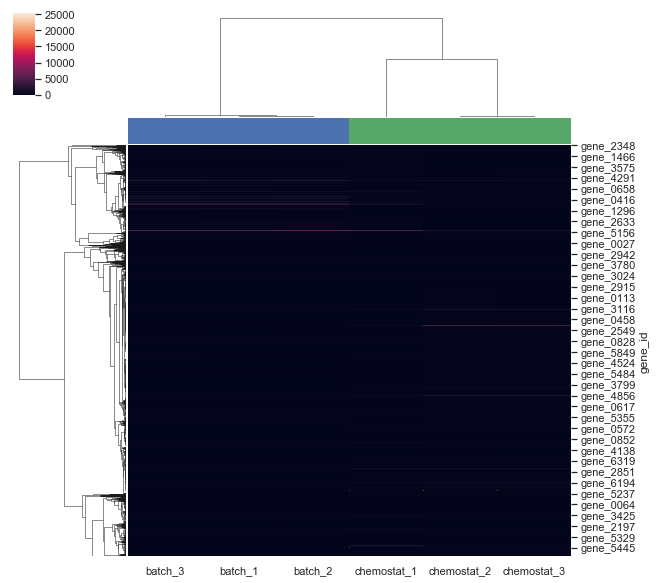

In [4]:
sample_colors = {'batch_1':'b',  # b : blue
                 'batch_2':'b',
                 'batch_3':'b',
                 'chemostat_1':'g', # g: green
                 'chemostat_2':'g',
                 'chemostat_3':'g'}
colors = df.columns.map(sample_colors)
sns.clustermap(df, method='average', metric='correlation', col_colors=colors)

In [5]:
# 平均TPMがTop-10の遺伝子だけ抜き出し
top10_df = df.loc[ df.mean(axis=1).sort_values(ascending=False).index[:10]  , :]

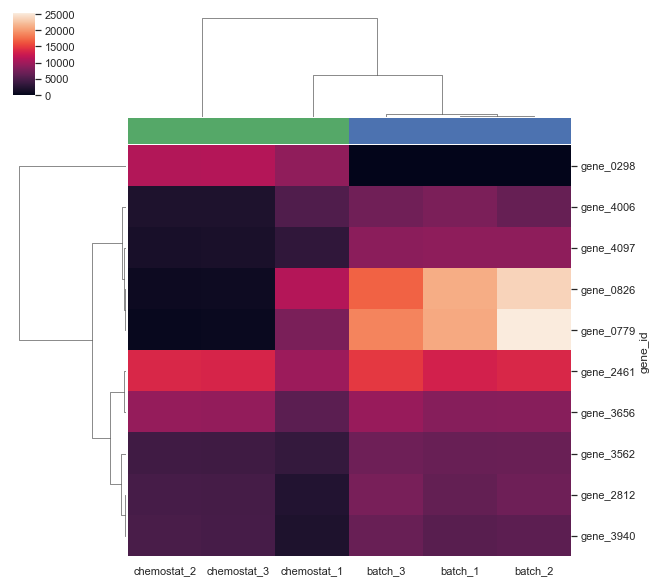

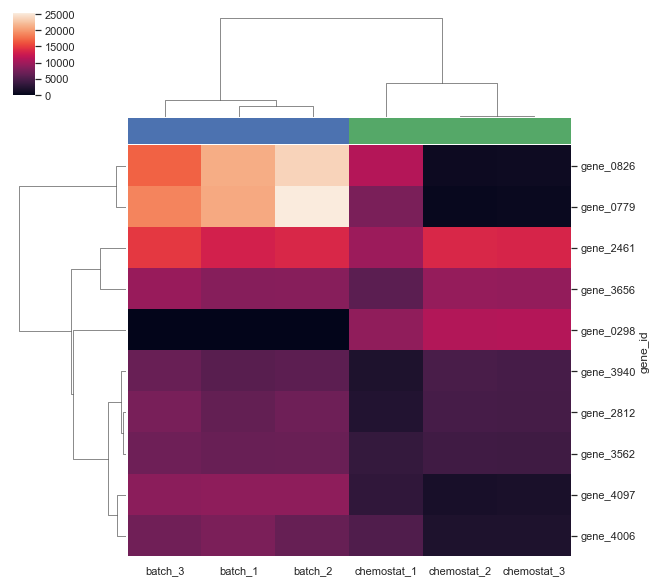

In [6]:
# サンプル間の距離計算手法、クラスター間の距離計算手法による違い
sns.clustermap(top10_df, method='average', metric='correlation', col_colors=colors)
sns.clustermap(top10_df, method='ward', metric='euclidean', col_colors=colors)

# PCA (Principal Component Analysis; 主成分分析)

In [7]:
import sklearn.decomposition

In [8]:
# PCA実行
pca = sklearn.decomposition.PCA()
coords = pca.fit_transform(df.transpose().values)

In [9]:
def scatter_plot(coords, sample_labels, colors):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(coords[:, 0], coords[:, 1], color=colors)
    for i, sample_label in enumerate(sample_labels):
        ax.annotate(sample_label, xy=(coords[i, :2]), xytext=(10,10),
                    textcoords='offset points', color=colors[i],
                   arrowprops={'arrowstyle':'-', 'edgecolor':colors[i]})
    plt.show()

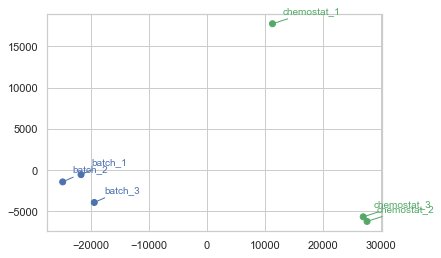

In [10]:
scatter_plot(coords, df.columns, colors)

In [11]:
# z-score 正規化
import sklearn.preprocessing
values = df.values
scaler = sklearn.preprocessing.StandardScaler()
std_values = scaler.fit_transform(values)
std_df = pd.DataFrame(std_values, index=df.index, columns=df.columns)

print('\nRaw values')
print('Average :')
print(df.mean(axis=0))
print('Standard deviation:')
print(df.std(axis=0))
print('\nStandardized values')
print('Average :')
print(std_df.mean(axis=0))
print('Standard deviation:')
print(std_df.std(axis=0))

# おんなじことを自分で計算する場合
# std_values = (df.values - df.values.mean(axis=0)) / df.values.std(axis=0)
# std_df2 = pd.DataFrame(std_values, index=df.index, columns=df.columns)
# print('\nStandardized values 2')
# print('Average :')
# print(std_df2.mean(axis=0))
# print('Standard deviation:')
# print(std_df2.std(axis=0))


Raw values
Average :
batch_1        169.721656
batch_2        169.721656
batch_3        169.721656
chemostat_1    169.721656
chemostat_2    169.721656
chemostat_3    169.721656
dtype: float64
Standard deviation:
batch_1        684.000759
batch_2        725.697540
batch_3        668.107832
chemostat_1    523.169094
chemostat_2    463.068356
chemostat_3    456.265310
dtype: float64

Standardized values
Average :
batch_1        2.639418e-17
batch_2       -3.819454e-17
batch_3       -1.098540e-17
chemostat_1    4.070064e-18
chemostat_2   -2.068007e-17
chemostat_3    1.537580e-17
dtype: float64
Standard deviation:
batch_1        1.000085
batch_2        1.000085
batch_3        1.000085
chemostat_1    1.000085
chemostat_2    1.000085
chemostat_3    1.000085
dtype: float64


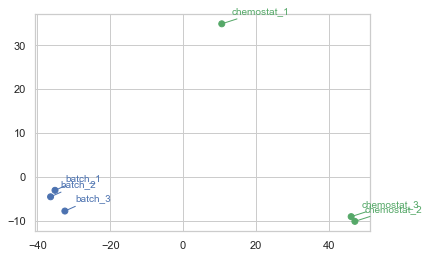

In [12]:
# 標準化されたデータでPCA実行
pca = sklearn.decomposition.PCA()
coords = pca.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

In [13]:
# 各主成分の「寄与率」
print(['{:.2f}%'.format(x*100) for x in pca.explained_variance_ratio_])

['83.60%', '15.44%', '0.72%', '0.15%', '0.09%', '0.00%']


# MDS (Multidimensional scaling; 多次元尺度構成法)

## metric MDS = PCoA (Principal Coordinate Analysis; 主座標分析)
構成する「距離行列」が、距離関数の要件を満たしている場合に適用可能な手法。
Bray-Curtis dissimilarityなど、三角不等式の要件を満たさない非類似性指標があるので注意。こういう場合はPCoAではなくnMDSを使う。
（しかしデータによっては偶然「計算できてしまう」ためにBray-Curtis dissimilarityでPCoAをやっている論文も...）

In [14]:
import sklearn.manifold

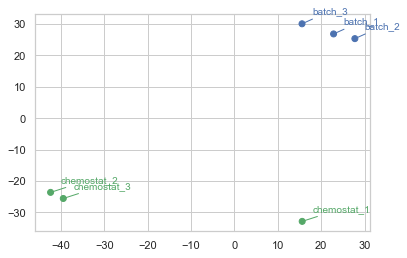

In [15]:
# デフォルトではユークリッド距離でサンプル間距離行列を計算。この場合、数学的には主成分分析と等価。
# ただしscikit-learnのMDS実装はiterativeに最適化するアルゴリズムになっているため（classical MDSは固有値分解に基づく手法）、
# ランダムな初期値の影響で実行のたびに結果が若干変わる
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='euclidean')
coords = mds.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

In [16]:
# 距離行列の計算
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(std_df.transpose().values))
print(distance_matrix)

#自分で距離行列を作る場合（上の一行とおんなじ計算結果）
# from scipy.spatial.distance import euclidean
# values = std_df.transpose().values
# distance_matrix_2 = []
# for i in range(values.shape[0]):
#     vec = []
#     for j in range(values.shape[0]):
#         vec.append(euclidean(values[i, :], values[j, :]))
#     distance_matrix_2.append(vec)
# print(np.array(distance_matrix_2))

[[ 0.          7.28339392  9.69107705 59.61010899 82.77231685 81.67822634]
 [ 7.28339392  0.         12.78566821 61.70292581 83.98067436 82.95451012]
 [ 9.69107705 12.78566821  0.         60.95272024 80.04381455 78.9356052 ]
 [59.61010899 61.70292581 60.95272024  0.         58.07482836 56.58996149]
 [82.77231685 83.98067436 80.04381455 58.07482836  0.          4.47298822]
 [81.67822634 82.95451012 78.9356052  56.58996149  4.47298822  0.        ]]


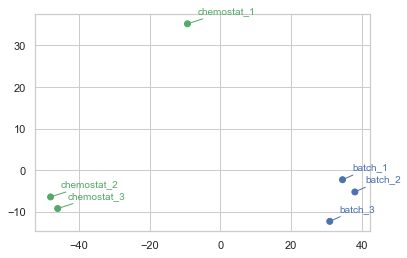

In [17]:
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

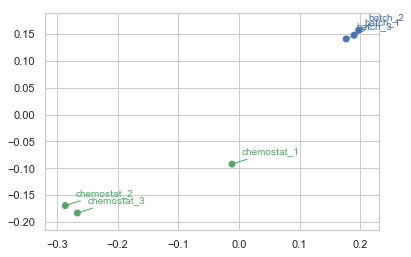

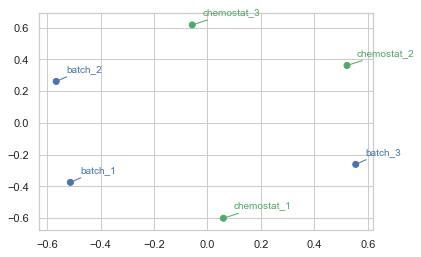

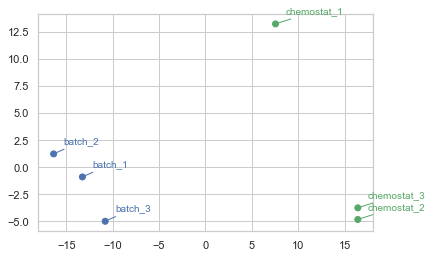

In [18]:
# 相関係数で計算した距離（1 - 相関係数）
distance_matrix = squareform(pdist(std_df.transpose().values, 'correlation'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)
# Jaccard距離
distance_matrix = squareform(pdist(std_df.transpose().values, 'jaccard'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)
# チェビシェフ距離
distance_matrix = squareform(pdist(std_df.transpose().values, 'chebyshev'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

## non-metric MDS (非計量多次元尺度構成法)
構成する「距離行列」が、距離関数の要件を満たさない場合に適用する。

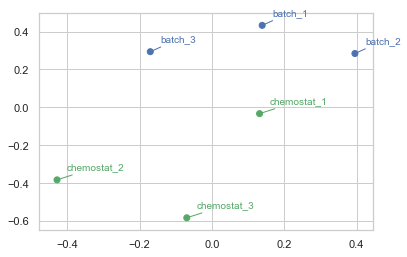

In [19]:
# Bray-Curtis 非類似度指標による計算
distance_matrix = squareform(pdist(std_df.transpose().values, 'braycurtis'))
nmds = sklearn.manifold.MDS(n_components=2, metric=False, dissimilarity='precomputed')
coords = nmds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

# 多様体学習

## Isomap

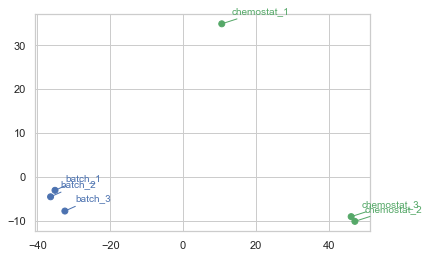

In [20]:
isomap = sklearn.manifold.Isomap(n_components=2)
coords = isomap.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

## LLE (Locally Linear Embedding)

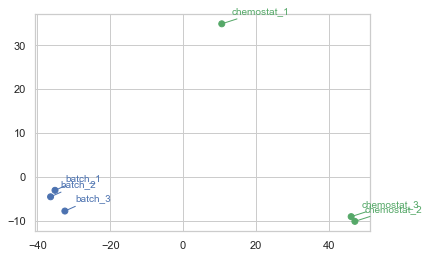

In [21]:
lle = sklearn.manifold.LocallyLinearEmbedding(n_components=2)
coords = isomap.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

## t-SNE (t-distributed Stochastic Neighbor Embedding)

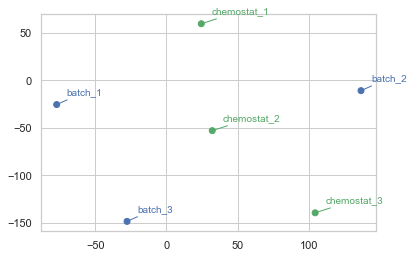

In [22]:
tsne = sklearn.manifold.TSNE(n_components=2)
coords = tsne.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

## UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
[参考論文](https://arxiv.org/abs/1802.03426)
```bash
$conda install -c conda-forge umap-learn
```

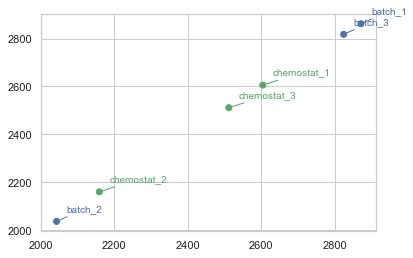

In [23]:
import umap
coords = umap.UMAP(n_components=2, n_neighbors=5, init='random').fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

# クラスタリング

## NMF (Non-negative Matrix Factorization; 非負値行列因子分解)

X ~ W * H


X: non-negative matrix. (n, m)

W: non-negative matrix. (n, k)

H: non-negative matrix. (k, m)

In [24]:
model = sklearn.decomposition.NMF(n_components=2)
W = model.fit_transform(df.values)
H = model.components_

print('Original shape=',df.values.shape)
print('W shape =',W.shape)
print('H shape =',H.shape)

Original shape= (5892, 6)
W shape = (5892, 2)
H shape = (2, 6)


[[177.52828588 188.17519289 169.82100783  62.56697448   4.36203027
    6.39263374]
 [  2.10760132   0.           9.94428817 107.32702137 150.56887151
  147.74777177]]


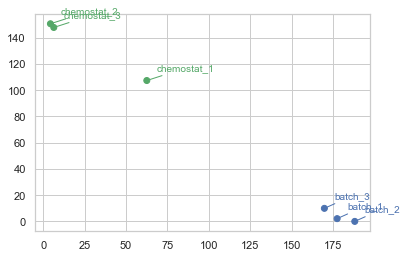

In [25]:
# 次元削減としての利用
print(H)
scatter_plot(H.T, df.columns, colors)

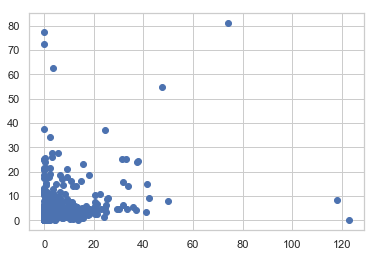

In [26]:
# それぞれの因子に強く寄与している遺伝子はなにか？
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(W[:,0], W[:,1])
plt.show()

In [27]:
pd.set_option('display.width', 800)
# 因子１　に強く寄与する遺伝子
top10_factor1 = df.index[ np.argsort(W[:,0] - W[:,1])[::-1][:10] ]
print(df.loc[top10_factor1, :])

                batch_1       batch_2       batch_3   chemostat_1  chemostat_2  chemostat_3
gene_id                                                                                    
gene_0779  21119.485911  25422.792819  18890.417315   7902.056291   606.030797   685.000023
gene_0826  21258.888458  23819.774452  17080.419779  11303.532339   829.708559   998.974649
gene_4097   9061.905864   9095.550971   8899.221935   3262.474042  1664.113115  1736.727099
gene_3130   7224.972645   7533.859512   7018.895506   3437.394486   463.915092   606.848281
gene_2599   6559.132661   6699.856532   6872.469372   2366.082920   886.307683   979.241334
gene_1498   8115.321890   6861.758570   7153.679282   5299.417018   962.679427  1088.263015
gene_5875   6448.214875   6617.738782   6307.752311   2515.637579  1092.437245  1186.343452
gene_2215   5911.128296   6120.747318   5991.234498   2682.700671   837.370449   876.276413
gene_4006   8007.974126   6773.616583   7291.489410   5338.444813  2047.207624  

In [28]:
# 因子2　に強く寄与する遺伝子
top10_factor2 = df.index[ np.argsort(W[:,0] - W[:,1])[:10] ]
print(df.loc[top10_factor2, :])

              batch_1     batch_2     batch_3   chemostat_1   chemostat_2   chemostat_3
gene_id                                                                                
gene_0298   45.042422   35.767036   30.200371   9196.322897  11172.024511  11295.662109
gene_5880   87.453317   39.871201   35.627167   6637.188507  11573.655851  10885.756220
gene_1889  251.756248   62.569858   66.609576  13721.235033   6890.263690   7083.673945
gene_3497    7.893641    5.577540    4.537712   2536.458776   5995.305486   6325.992801
gene_1038  879.387455  285.368591  249.348602   4679.865163   4790.905781   4849.315625
gene_0067  256.210446  222.207510  222.250893   1684.904306   4344.786047   4134.227181
gene_5965    5.361636    9.804394    8.812062   3305.048858   3459.961310   3602.990711
gene_5258  185.588611  177.587969  189.294610    688.035842   4721.948770   4054.903162
gene_4255  175.755367   35.160584   22.595342   8576.662350   2240.979298   2196.650104
gene_4882   60.851309   53.56364